In [1]:
import os
import random
import gensim
# import scopus
import pybliometrics.scopus as scopus
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets

from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')

import logging
logging.getLogger().setLevel(logging.INFO)

# some python 3 trickery
import sys
if sys.version_info[0] >= 3:
    unicode = str

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
import PyPDF2
import textract

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get current working directory
current_dir = os.getcwd()

print("Current directory:", current_dir)

Output_folder='Analysis_All_Mend_Collection_pybliometrics_HP'

Current directory: C:\Users\Mhdella\iHelm\Lit_Rev\Analysis_Mend


In [3]:
## Create the output folder
folder_path = r''+Output_folder
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Parameters

In [4]:
seed = 70 # seed for NMF topic model
num_topics = 12

# # query = 'title-abs-key("short sea shipping")'
# query = 'title-abs-key( "Short Sea shipping ") AND PUBYEAR IS 2022'


labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6 # seed for t-SNE visualization
vis_angle = 135 # rotation angle for visualization

In [5]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

# Import

### Upload data that have file path to upload the corresponding PDF files

The Mendeley pdf files exported to csv file by using Jabref.

Open the .bib-files in Jabref and export them as OpenOffice .csv-files. You find the option under the menu File, Export

This is the difference between the csv exported from Online websites and from Jabref since the online website doesn't give these paths of pdf files, and also the online website stuck when the data is big!


In [6]:
meta_df = pd.read_excel('./Mend_Stats/Outputs_HP/'+'df_All_Mend_Topics.xlsx')

print(meta_df.shape)
meta_df.head()
# meta_df.info

(3451, 7)


,Unnamed: 0,title,abstract,topics_3max,topics_max,topics_score,topics_id
0,0,The path of the smart grid,NaN,"['Topic 2 (energy, renewable, electricity, sys...","Topic 2 (energy, renewable, electricity, syste...","[0.0, 0.0, 0.449579754312077, 0.01501546964171...","['Topic 0 (solar, irradiance, radiation, cloud..."
1,1,Regression and Generalized Additive Model to E...,NaN,"['Topic 9 (learning, machine, data, prediction...","Topic 9 (learning, machine, data, prediction, ...","[0.1239373081018689, 0.0021504386998764057, 0....","['Topic 0 (solar, irradiance, radiation, cloud..."
2,2,A Multi-model Combination Approach for Probabi...,Short-term probabilistic wind power forecastin...,"['Topic 7 (forecasting, ensemble, probabilisti...","Topic 7 (forecasting, ensemble, probabilistic,...","[0.0, 0.0, 0.13723117733912701, 0.300800738546...","['Topic 0 (solar, irradiance, radiation, cloud..."
3,3,The Malaysia-Japan Model on Technology Partner...,NaN,"['Topic 2 (energy, renewable, electricity, sys...","Topic 2 (energy, renewable, electricity, syste...","[0.013558911105261586, 0.0, 0.5920782319984649...","['Topic 0 (solar, irradiance, radiation, cloud..."
4,4,An artificial neural network to assess the imp...,NaN,"['Topic 11 (network, neural, graph, artificial...","Topic 11 (network, neural, graph, artificial, ...","[0.20334659744097316, 0.0, 0.11536774187076915...","['Topic 0 (solar, irradiance, radiation, cloud..."


In [7]:
# !pip install --upgrade pandasimport pandas as pd
# print(pd.__version__)
###1.3.4 in Dell
###1.4.1

In [8]:
# !pip install pandas==<desired_version>

### Load saved data

In [9]:
saved_meta_df=pd.read_pickle('All_Mend_Collection_pybliometrics_HP/df_All_incld_bodytext_kywrd')
saved_meta_df.shape

(9170, 33)

In [10]:
saved_meta_df.columns

Index(['BibliographyType', 'ISBN', 'Identifier', 'Author', 'Title', 'Journal',
       'Volume', 'Number', 'Month', 'Pages', 'Year', 'Address', 'Note', 'URL',
       'Booktitle', 'Chapter', 'Edition', 'Series', 'Editor', 'Publisher',
       'ReportType', 'Howpublished', 'Institution', 'Organizations', 'School',
       'Annote', 'Custom1', 'Custom2', 'Custom3', 'Custom4', 'Custom5',
       'body_text', 'keywords'],
      dtype='object')

In [11]:
meta_df=saved_meta_df

## Analysis Graphs

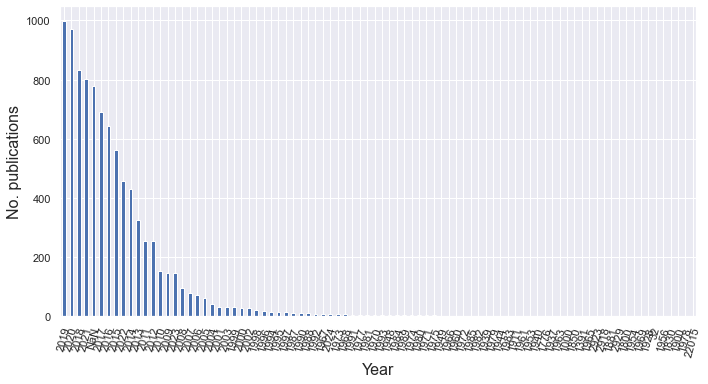

In [12]:
meta_df['Year'] = meta_df['Year'].fillna('NaN').astype(str).str.replace(".0","",regex=False)

prepare_fig(1.9, 1.9)
pd.value_counts(meta_df['Year']).plot.bar()

plt.ylabel("No. publications",fontsize=16)
plt.xlabel("Year",fontsize=16)
plt.xticks(rotation = 75); 

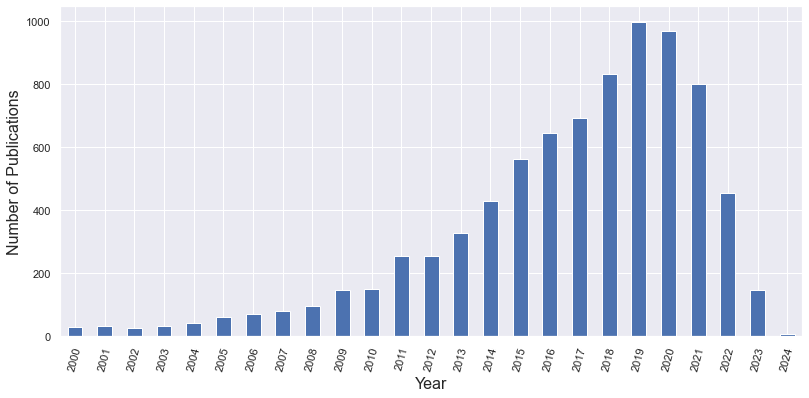

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming meta_df is your DataFrame containing publication data
# and 'Year' is the column representing the publication years

# Convert the 'Year' column to integers
meta_df['Year'] = pd.to_numeric(meta_df['Year'], errors='coerce')

# Filter the DataFrame for the 2000s
meta_df_2000s = meta_df[meta_df['Year'].between(2000, 2025)]

# Count the occurrences of each year
ry = pd.value_counts(meta_df_2000s['Year'])
ry.index = ry.index.astype(int)
ry = ry.astype(int)

# Sort the values based on the year
ryns = ry.sort_index()

# Plotting
prepare_fig(1.9, 1.9)
ryns.plot.bar()
plt.ylabel("Number of Publications", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.xticks(rotation=75)

plt.tight_layout() 
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_publication_years_2000s.png', dpi=300)

plt.show()

Text(0.5, 0, 'Year')

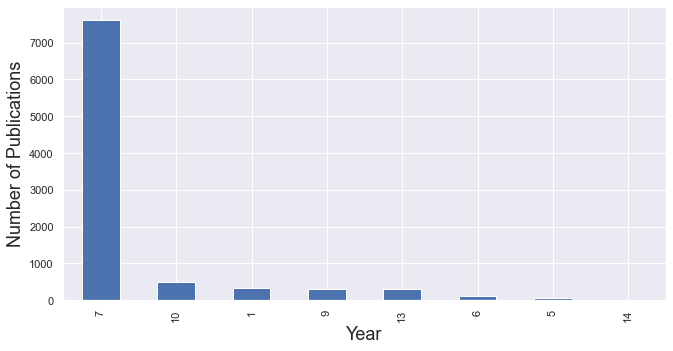

In [14]:
prepare_fig(1.8, 1.8)
pd.value_counts(meta_df['BibliographyType']).plot.bar()

plt.ylabel("Number of Publications",fontsize=18)
plt.xlabel("Year",fontsize=18)

## Note:
For the above plot, to changing the numbers of item types, we will upload another data from SSS_Refs_July29_2022.csv, which has the names of item types rather than numbers.

This csv file was converted from the Bibtex of SSS Mendeley files by using this online website https://www.bibtex.com/c/bibtex-to-csv-converter/


In [15]:
### meta_df2 = pd.read_csv('./Mend_Stats/SSS_Mend_excel/SSS_Refs_July29_2022.csv')

meta_df2 = pd.read_csv('./Mend_Stats/Mend_Collection/SSS_Mend_Dell_Nov2023.csv')

meta_df2.columns

Index(['Item type', 'Authors', 'Title', 'Journal', 'Publication year',
       'Volume', 'Issue', 'Pages', 'Publisher', 'Date published', 'ISBN',
       'ISSN', 'URLs', 'DOI', 'Abstract', 'Keywords', 'Sub-type',
       'Pages cited'],
      dtype='object')

In [16]:
meta_df2['Sub-type'].unique()
meta_df2['Item type'].unique()

array(['Journal Article', 'Report', 'Ph.D. Thesis', 'Book',
       'Miscellaneous'], dtype=object)

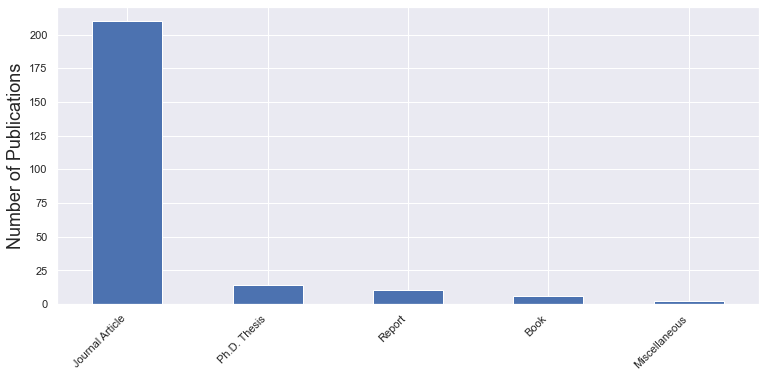

In [17]:
prepare_fig(1.8, 1.8)
pd.value_counts(meta_df2['Item type']).plot.bar()

plt.ylabel("Number of Publications",fontsize=18)
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels by 45 degrees and align to the right

plt.tight_layout()
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_publication_types.png', dpi=300)

plt.show()


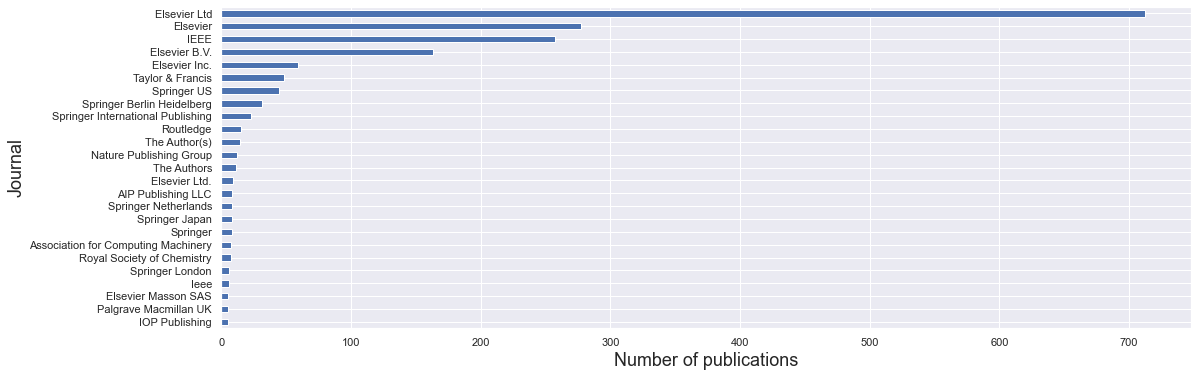

In [18]:
# rj = pd.value_counts(meta_df['Journal'])
rj = pd.value_counts(meta_df['Publisher'])

prepare_fig(2.8, 1.8)
rj[0:25].plot.barh()  # Use barh for horizontal bar plot

plt.xlabel("Number of publications", fontsize=18)  # Swap x-axis and y-axis labels
plt.ylabel("Journal", fontsize=18)  # Swap x-axis and y-axis labels

plt.gca().invert_yaxis()  # Reverse the y-axis

plt.tight_layout()
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_y_publisher_publications.png', dpi=300)

plt.show()

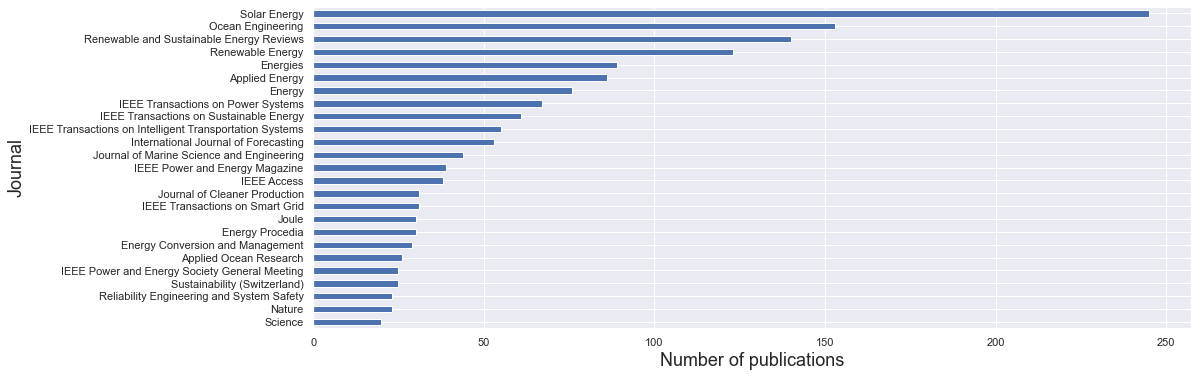

In [19]:
rj = pd.value_counts(meta_df['Journal'])

prepare_fig(2.8, 1.8)
rj[0:25].plot.barh()  # Use barh for horizontal bar plot

plt.xlabel("Number of publications", fontsize=18)  # Swap x-axis and y-axis labels
plt.ylabel("Journal", fontsize=18)  # Swap x-axis and y-axis labels

plt.gca().invert_yaxis()  # Reverse the y-axis

plt.tight_layout()
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_y_journal_publications.png', dpi=300)

plt.show()

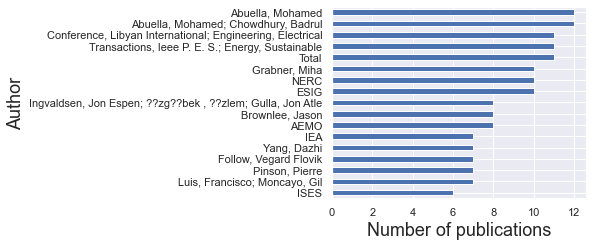

In [20]:
r_a = pd.value_counts(meta_df['Author'])

prepare_fig(1.4, 1.2)
r_a[0:17].plot.barh()  # Use barh for horizontal bar plot

plt.xlabel("Number of publications", fontsize=18)
plt.ylabel("Author", fontsize=18)

plt.gca().invert_yaxis()  # Reverse the y-axis

plt.tight_layout()

# Save the plot to a file
plt.savefig(Output_folder+'/Fig_publications_per_author.png', dpi=300)

plt.show()

# Topic Modeling

## Preprocessing

In [21]:
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 152 stopwords
loaded 42 bigrams
loaded 2 stem rules


In [22]:
# meta_df['keywords']=meta_df.Custom3

In [23]:
meta_df['Abstract']=meta_df['Custom1']
meta_df['Abstract'].fillna('', inplace=True)

meta_df['kw']=meta_df['keywords']
meta_df['kw']=meta_df['kw'].astype("string");
type(meta_df.body_text[1])
type(meta_df.kw[1])

str

In [24]:
texts = []; indx=[]
for p in range(len(meta_df)):
    try:
        text = (meta_df.Title[p] or '') + ' ' + (meta_df.Abstract[p] or '') + ' ' + (meta_df.kw[p] or '')
        text = text.lower()
        text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
        texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items
        indx.append(p)
   
    except:  ## To avoid KeyError
        continue 

In [25]:
print(len(meta_df), len(texts))

9170 8971


In [26]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,42257,Yes
1,of,27979,Yes
2,and,24105,Yes
3,to,15658,Yes
4,a,15025,
5,in,14344,Yes
6,for,10578,Yes
7,power,9899,
8,nan,8881,
9,data,8844,


In [27]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
# Create a DataFrame for the top 250 bigrams
df_bigrams = pd.DataFrame(
    [
        (w, two_count[w], 'Yes' * (w in bigrams))
        for w in top_k(two_count, 250)
    ],
    columns=['bigram', 'count', ''])

# Save the DataFrame to an Excel file
df_bigrams.to_excel(Output_folder+'/bigrams_results.xlsx', index=False)
df_bigrams

,bigram,count,
0,"(wind, power)",1394,
1,"(machine, learning)",1173,Yes
2,"(short, term)",1124,
3,"(renewable, energy)",970,
4,"(neural, network)",949,
5,"(neural, networks)",923,
6,"(climate, change)",881,
7,"(power, system)",848,
8,"(solar, power)",821,
9,"(u, s)",661,


In [28]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [29]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [30]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()

# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))

# Create a DataFrame for the top 250 stemmed tokens
df_result = pd.DataFrame(
    [
        (token, stemming[token], unstemming[stemming[token]], word_count[token])
        for token in top_k(word_count, k=250)
    ],
    columns=['Original', 'Stem', 'Unstem', 'Count']
)

# Save the DataFrame to an Excel file
excel_filename = 'stemming_results.xlsx'
df_result.to_excel(Output_folder+'/stemming_results.xlsx', index=False)
df_result


INFO:root:stemming reduced 42755 to 32680 tokens


,Original,Stem,Unstem,Count
0,power,power,power,9899
1,nan,nan,nan,8881
2,data,data,data,8484
3,energy,energi,energy,7921
4,model,model,model,7109
5,solar,solar,solar,5935
6,system,system,system,5378
7,forecasting,forecast,forecasting,5282
8,wind,wind,wind,4593
9,models,model,model,4248


In [70]:
len(stemmed_texts)

8971

## Create dictionary

In [71]:
# Remove papers with less than 25 words after preprocessing
# n = len(meta_df)
n = len(texts)
indices = [i for i in range(len(texts)) if len(stemmed_texts[i]) > 25]
# papers = [papers[i] for i in indices]
papers = [meta_df.Title[i] for i in indx]
final_texts = [stemmed_texts[i] for i in indices]
filtered_meta_df = meta_df[meta_df.index.isin(indices)]

print('papers: {} (removed {})'.format(len(papers), n - len(texts)))
print(filtered_meta_df.shape)
print(meta_df.shape)

papers: 8971 (removed 0)
(3302, 35)
(9170, 35)


In [72]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:built Dictionary<31615 unique tokens: ['1p', '20grid', '20nrcanada', '20technology', '21st']...> from 3377 documents (total 902796 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<31615 unique tokens: ['1p', '20grid', '20nrcanada', '20technology', '21st']...> from 3377 documents (total 902796 corpus positions)", 'datetime': '2023-12-11T00:11:44.479644', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.17134-SP0', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 2 tokens: [('nan', 3297), ('model', 1816)]...
INFO:gensim.corpora.dictionary:keeping 31613 tokens which were in no less than 0 and no more than 1688 (=50.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary<31613 unique tokens: ['1p', '20grid', '20nrcanada', '2

papers: 3377
dictionary size: 5425


## Topic modeling

In [33]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq

In [34]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [35]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

violation: 1.0
violation: 0.22190782947583992
violation: 0.13972300232347887
violation: 0.12255844488983514
violation: 0.11352833764115179
violation: 0.09130831053229282
violation: 0.06635665314731666
violation: 0.04669152163654209
violation: 0.03371138481803234
violation: 0.025296364922192675
violation: 0.019382656922666948
violation: 0.015053386075318635
violation: 0.011983839161478702
violation: 0.009614079514257459
violation: 0.007963930992310589
violation: 0.006789651876337294
violation: 0.005992044901245909
violation: 0.00541741372622667
violation: 0.004981934434082694
violation: 0.004626794499856396
violation: 0.0043400646839800334
violation: 0.004089804445449792
violation: 0.0038360616173156127
violation: 0.0036239604431489354
violation: 0.0034272997213816133
violation: 0.003241765862697189
violation: 0.003065809362480347
violation: 0.0029064204882176853
violation: 0.0027585210092473406
violation: 0.002618252255189969
violation: 0.002481738845330645
violation: 0.002352129968077

In [36]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,forecasting (0.12),ensemble (0.018),probabilistic (0.014),weather (0.012),load (0.011),ahead (0.011),power (0.0095),methods (0.0092),day (0.0088),error (0.0087)
1,B,ship (0.069),fuel (0.025),emissions (0.02),speed (0.018),consumption (0.017),sea (0.012),operation (0.012),efficiency (0.0091),wave (0.0083),port (0.0073)
2,C,energy (0.043),renewable (0.018),electricity (0.016),system (0.015),storage (0.012),cost (0.0097),demand (0.0087),grid (0.0084),power (0.0082),generation (0.0074)
3,D,wind (0.12),power (0.049),ramp (0.024),speed (0.022),farms (0.017),generation (0.011),turbine (0.01),operation (0.0091),system (0.0087),events (0.0085)
4,E,prediction (0.036),data (0.019),performance (0.011),methods (0.0095),regression (0.0094),estimation (0.0083),machinelearning (0.0081),features (0.0075),algorithm (0.0069),error (0.0061)
5,F,pv (0.085),power (0.043),photovoltaic (0.025),system (0.022),plants (0.021),output (0.017),generation (0.012),grid (0.01),variables (0.01),module (0.0086)
6,G,solar (0.056),irradiance (0.036),radiation (0.017),cloud (0.017),sky (0.015),satellite (0.01),clear (0.0095),global (0.0093),variables (0.0089),image (0.0088)
7,H,trajectory (0.048),ais (0.033),vessel (0.032),clustering (0.03),traffic (0.025),maritime (0.024),data (0.022),detection (0.013),automatic (0.011),identification (0.01)
8,I,route (0.068),optimization (0.032),algorithm (0.024),weather (0.017),problem (0.011),objective (0.01),planning (0.01),voyage (0.0096),ship (0.0087),wave (0.0083)
9,J,research (0.012),review (0.0091),literature (0.0056),applications (0.0052),data (0.0047),system (0.0046),development (0.0046),transport (0.0046),technology (0.0041),challenges (0.004)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


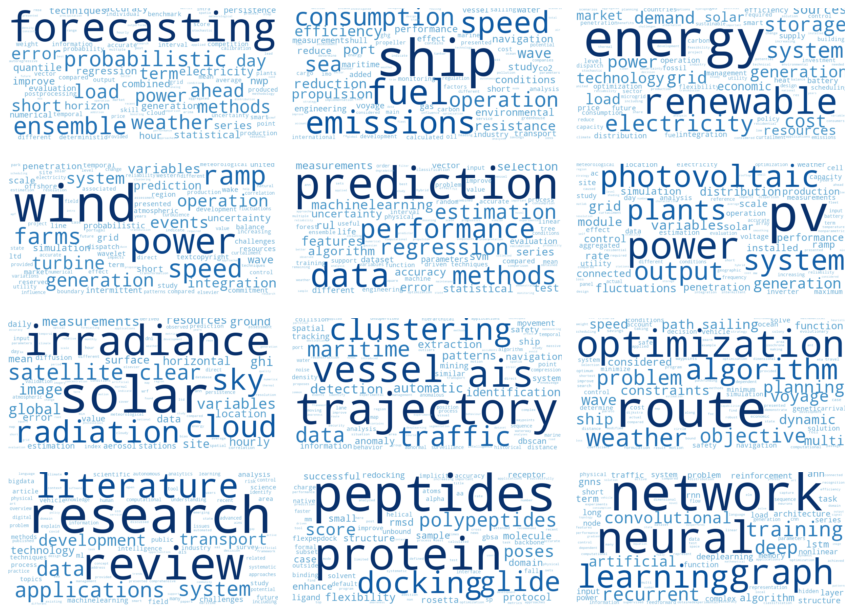

In [37]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)

plt.tight_layout()
# Save the figure to a file
plt.savefig(Output_folder+'/Fig_topics.png', dpi=300)
plt.show()


## Visualization

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3377 samples in 0.000s...
[t-SNE] Computed neighbors for 3377 samples in 0.382s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3377
[t-SNE] Computed conditional probabilities for sample 2000 / 3377
[t-SNE] Computed conditional probabilities for sample 3000 / 3377
[t-SNE] Computed conditional probabilities for sample 3377 / 3377
[t-SNE] Mean sigma: 0.022877
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.058441
[t-SNE] KL divergence after 1000 iterations: 1.106373


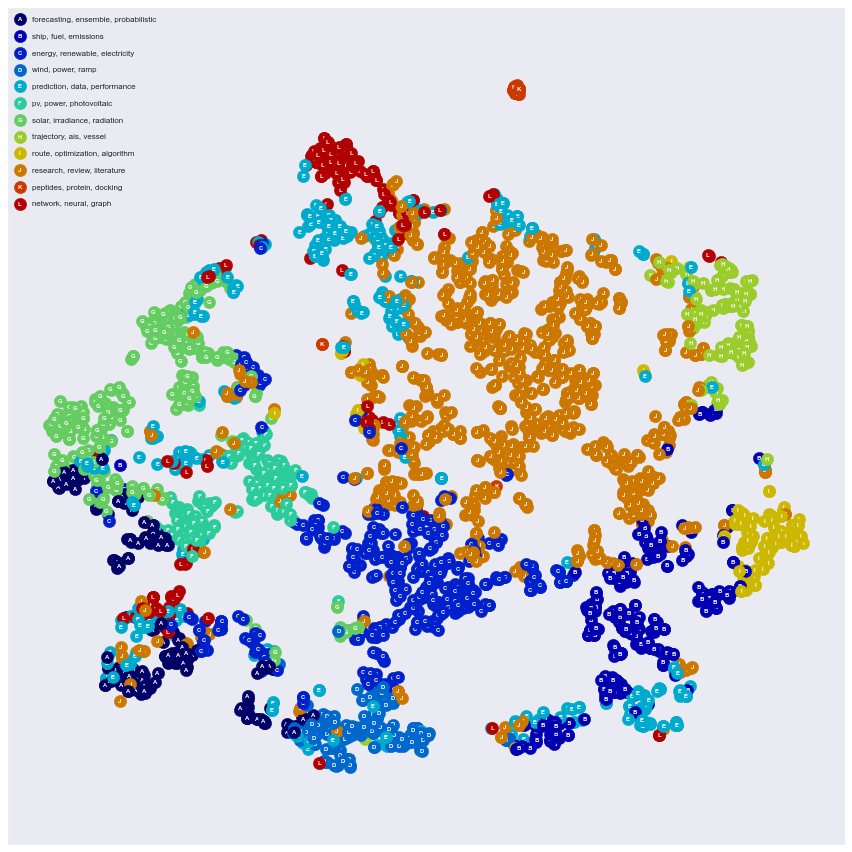

In [38]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.tight_layout()
# Save the figure to a file
plt.savefig(Output_folder+'/Fig_map_topics.png', dpi=300)
plt.show()

In [39]:
def on_select(i):
    print(meta_df.Title[i])
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    
    if 0 <= i < pos.shape[0]:
        
        plt.scatter(pos.T[0], pos.T[1], c='.5')
        plt.scatter(pos[i,0], pos[i,1], c='red',s=100, marker='x')
        plt.show()

        top_words = np.argsort(topic2token, axis=1)[:,::-1]
        ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]

        fig = prepare_fig(1, 2)
        plt.barh(range(num_topics), doc2topic[i])
        plt.xlim(0, 1)
        plt.ylim(num_topics, -1)
        plt.yticks(range(num_topics), ticks)
        plt.show()

        print(meta_df.Abstract[i])

# options = sorted([((meta_df.Title[i] or '').strip()[:50], i) for i, p in enumerate(papers)])
options = sorted([((meta_df.Title[i] or '').strip()[:50], i) for i in indx])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
widget

interactive(children=(Dropdown(description='i', options=(('$ FWLYH 3RZHU 0DQDJHPHQW 6FKHPH % DVHG RQ 5DPS 5DW'…

In [40]:
print("Length of meta_df:", len(meta_df))
print("Length of doc2topic:", len(doc2topic))

Length of meta_df: 9170
Length of doc2topic: 3377


In [41]:
# st=stop

NameError: name 'stop' is not defined

### Sort data with topics 
The documents are matched with top of 12 topics.

In [76]:
dic_topic = {'title': [], 'year': [], 'abstract': [], 'topics_3max': [], 'topics_max': [], 'topics_score': [], 'topics_id': []}

top_words = np.argsort(topic2token, axis=1)[:,::-1]
ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:7])) for l, w in zip(labels, top_words)]

# for i in indx[0:len(doc2topic)-1]:
#     dic_topic['title'].append(meta_df.Title[i])
#     dic_topic['abstract'].append(meta_df.Abstract[i])
#     dic_topic['topics_score'].append(list(doc2topic[i]))
#     dic_topic['topics_id'].append(ticks)
#     tops3=doc2topic[i].argsort()[::-1][0:3].tolist()
#     dic_topic['topics_3max'].append([ticks[tp] for tp in tops3])
#     topic_title= np.argmax(doc2topic[i])
#     dic_topic['topics_max'].append(ticks[topic_title]) 
    
# topics_df= pd.DataFrame(dic_topic)
# topics_df.head()

for i in range(len(doc2topic)):
    try:
        dic_topic['title'].append(meta_df.Title[i])
        dic_topic['year'].append(meta_df.Year[i])
        dic_topic['abstract'].append(meta_df.Abstract[i])
        dic_topic['topics_score'].append(list(doc2topic[i]))
        dic_topic['topics_id'].append(ticks)
        tops3=doc2topic[i].argsort()[::-1][0:3].tolist()
        dic_topic['topics_3max'].append([ticks[tp] for tp in tops3])
        topic_title= np.argmax(doc2topic[i])
        dic_topic['topics_max'].append(ticks[topic_title]) 
    except: continue
    
topics_df= pd.DataFrame(dic_topic)
topics_df['topics_id'] = topics_df['topics_max']

topics_df.head()

,title,year,abstract,topics_3max,topics_max,topics_score,topics_id
0,The path of the smart grid,2010.0,,"[C (energy, renewable, electricity, system, st...","C (energy, renewable, electricity, system, sto...","[0.01406603995067544, 0.0, 0.41641323666713337...","C (energy, renewable, electricity, system, sto..."
1,Regression and Generalized Additive Model to E...,2021.0,,"[E (prediction, data, performance, methods, re...","E (prediction, data, performance, methods, reg...","[0.08809942412623321, 0.0, 0.07499072154280675...","E (prediction, data, performance, methods, reg..."
2,A Multi-model Combination Approach for Probabi...,2018.0,Short-term probabilistic wind power forecastin...,"[E (prediction, data, performance, methods, re...","E (prediction, data, performance, methods, reg...","[0.2607478393216936, 0.0, 0.13222309161060214,...","E (prediction, data, performance, methods, reg..."
3,The Malaysia-Japan Model on Technology Partner...,2015.0,,"[C (energy, renewable, electricity, system, st...","C (energy, renewable, electricity, system, sto...","[0.009235001912294807, 0.0, 0.5583044054493996...","C (energy, renewable, electricity, system, sto..."
4,An artificial neural network to assess the imp...,2016.0,,"[L (network, neural, graph, learning, training...","L (network, neural, graph, learning, training,...","[0.16464958107642885, 0.0, 0.1106113284033923,...","L (network, neural, graph, learning, training,..."


In [77]:
# print(filtered_meta_df.shape)
print(meta_df.shape)
# print(filtered_df.shape)
print(len(doc2topic))
print(topics_df.shape)

(9170, 35)
3377
(3307, 7)


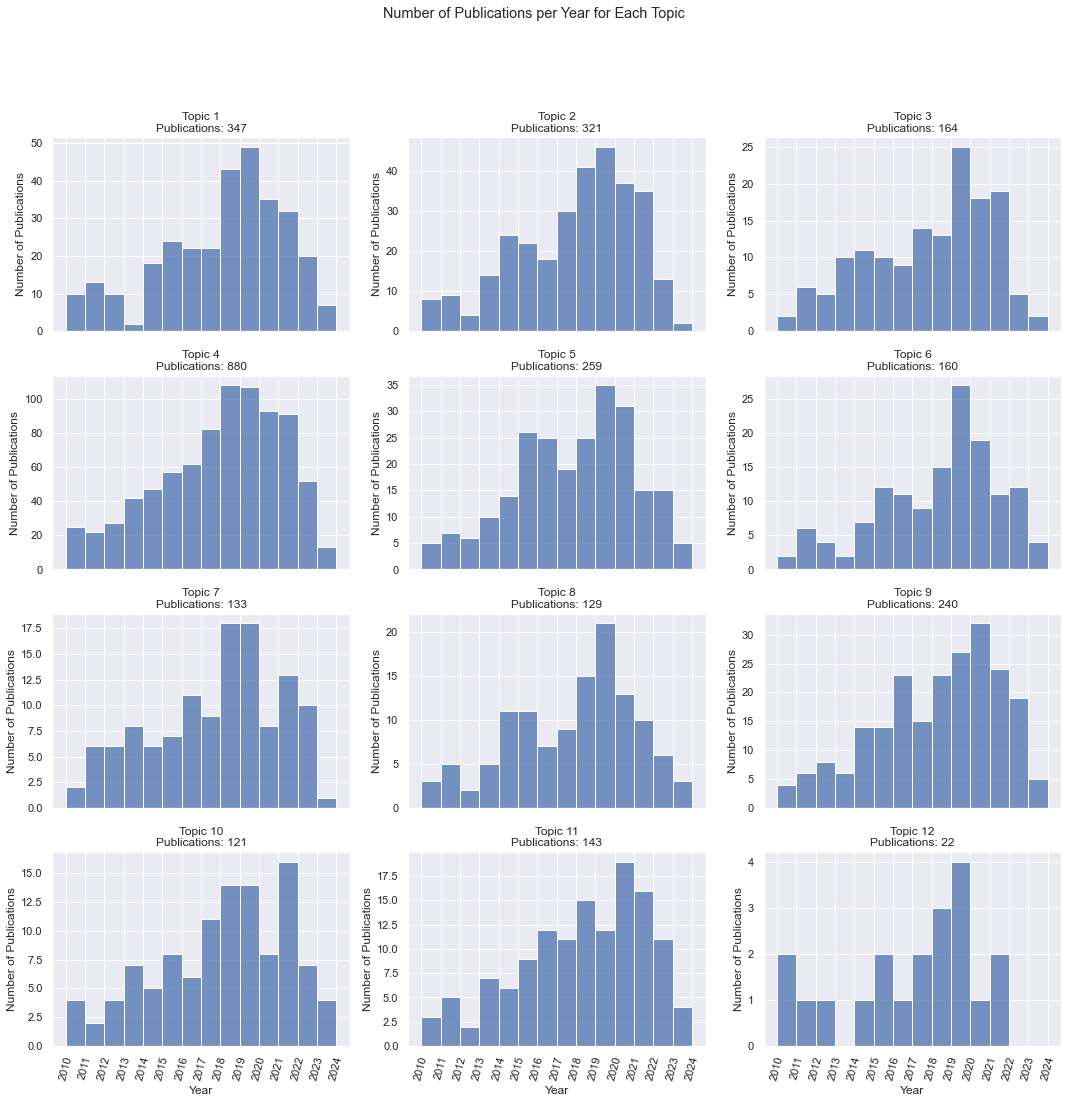

In [97]:
# Year_lower=2000
Year_lower=2010
Year_upper=int(topics_df['year'].max())
               
# Assuming 'year' is a numeric column in your DataFrame
# If it's not, you may need to convert it to numeric type first
topics_df['year'] = pd.to_numeric(topics_df['year'], errors='coerce')

# Set up the subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), sharex=True)
fig.suptitle('Number of Publications per Year for Each Topic', y=1.02)

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Define fixed bin edges
bin_edges = range(Year_lower, Year_upper + 1, 1)

# Iterate through each unique topic_id and create a subplot
for i, topic_id in enumerate(topics_df['topics_id'].unique()):
    topic_data = topics_df[(topics_df['topics_id'] == topic_id) & (topics_df['year'] > 2000)]
    sns.histplot(data=topic_data, x='year', ax=axes[i], bins=bin_edges, kde=False)
    
    # Set subplot title and labels
    pub_count = len(topic_data)
    axes[i].set_title(f'Topic {i + 1}\nPublications: {pub_count}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Number of Publications')
    
    # Set x-axis ticks for years after 2000
    axes[i].set_xticks(bin_edges)
    
    # Set x-axis tick labels and rotate them for better visibility
    axes[i].set_xticklabels(axes[i].get_xticks(), rotation=75)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig(Output_folder+'/Fig_years_topic.png', dpi=300)

# Show the plota
plt.show()


In [47]:
st=stop

NameError: name 'stop' is not defined

In [45]:
meta_df3 = pd.read_excel('./Mend_Stats/Outputs_HP/'+'df_All_Mend_Topics.xlsx')
meta_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3451 entries, 0 to 3450
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    3451 non-null   int64 
 1   title         3451 non-null   object
 2   abstract      1358 non-null   object
 3   topics_3max   3451 non-null   object
 4   topics_max    3451 non-null   object
 5   topics_score  3451 non-null   object
 6   topics_id     3451 non-null   object
dtypes: int64(1), object(6)
memory usage: 188.9+ KB


In [46]:
meta_df4 = pd.read_pickle('All_Mend_Collection_pybliometrics_HP/df_All_incld_bodytext_kywrd')

meta_df4.info()

filtered_body_text = meta_df4['body_text'][(meta_df4['body_text'].notna()) & (meta_df4['body_text'] != '')]

# Display the content of the filtered 'body_text' column
print(filtered_body_text)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9170 entries, 0 to 9371
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BibliographyType  9170 non-null   int64  
 1   ISBN              1894 non-null   object 
 2   Identifier        8872 non-null   object 
 3   Author            8871 non-null   object 
 4   Title             9170 non-null   object 
 5   Journal           4356 non-null   object 
 6   Volume            3917 non-null   object 
 7   Number            4314 non-null   object 
 8   Month             143 non-null    object 
 9   Pages             5793 non-null   object 
 10  Year              8393 non-null   float64
 11  Address           19 non-null     object 
 12  Note              0 non-null      float64
 13  URL               2483 non-null   object 
 14  Booktitle         295 non-null    object 
 15  Chapter           1 non-null      object 
 16  Edition           11 non-null     object 


In [ ]:
# meta_df5 = pd.read_pickle('All_Mend_Collection_pybliometrics_Dell/df_All_incld_bodytext_kywrd')
# meta_df5.info()  ## Dell PC

# filtered_body_text = meta_df5['body_text'][(meta_df5['body_text'].notna()) & (meta_df5['body_text'] != '')]

# # Display the content of the filtered 'body_text' column
# print(filtered_body_text)

In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Define funding patterns
funding_patterns = [
    r'\bgrant\b',
    r'\bfund\b',
    r'\bsponsor\b',
    r'\bsupported by\b',
    r'\bfunded by\b',
    r'\bfinancial support\b',
    r'\bfinancially supported\b',
    # Add more patterns as needed
]

# Join all body_text into a single string
text = ' '.join(filtered_body_text)

# Extract sentences containing funding information based on patterns
funding_sentences = [sentence.strip() for sentence in re.split(r'[.!?]', text) if any(re.search(pattern, sentence, re.IGNORECASE) for pattern in funding_patterns)]

# Extract potential funding sources from the identified sentences
potential_funding_sources = []
for sentence in funding_sentences:
    # Extract text between the patterns
    matches = re.findall(r'(?:' + '|'.join(funding_patterns) + r').*?([^.,;]+)', sentence)
    potential_funding_sources.extend([match.strip() for match in matches])

# Convert to lowercase for consistency
potential_funding_sources = [source.lower() for source in potential_funding_sources]

# Remove common stopwords (customize this list as needed)
stopwords = ['the', 'and', 'of', 'for', 'with', 'by', 'on', 'at', 'in', 'to', 'from', 'an', 'as', 'is', 'was', 'were', 'are']
potential_funding_sources = [source for source in potential_funding_sources if source not in stopwords]

# Create a DataFrame for the cleaned names of funding sources
df_funding_sources = pd.DataFrame(potential_funding_sources, columns=['Funding Source'])



In [ ]:
funding_sentences
### potential_funding_sources

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Convert the list of funding sentences to a pandas DataFrame
df_fund = pd.DataFrame({'Funding Sentences': funding_sentences})
# df = pd.DataFrame({'Funding Sentences': potential_funding_sources})


# # Initialize the CountVectorizer
# count_vectorizer = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 3))

# # Fit and transform the text data
# count_matrix = count_vectorizer.fit_transform(df['Funding Sentences'])

# # Get feature names (phrases) from the CountVectorizer
# feature_names = count_vectorizer.get_feature_names_out()

# # Convert the count matrix to a DataFrame
# df_counts = pd.DataFrame(data=count_matrix.toarray(), columns=feature_names)

# # Sum the counts for each phrase across all funding sentences
# phrase_counts = df_counts.sum(axis=0)

# # Get the top N phrases (funding sources)
# top_n = 10
# top_phrases = phrase_counts.sort_values(ascending=False).head(top_n)

# # Plot the bar plot for the top funding sources
# plt.figure(figsize=(10, 6))
# top_phrases.plot(kind='bar', color='skyblue')
# plt.xlabel('Funding Source')
# plt.ylabel('Count')
# plt.title(f'Top {top_n} Funding Sources based on CountVectorizer')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

In [ ]:
df_fund.to_excel(Output_folder+'/All_Mend_text_funding_sources.xlsx', index=False)
df_fund

In [ ]:
import spacy
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract organizations (potential funding sources) from text
def extract_organizations(text):
    doc = nlp(text)
    organizations = [ent.text for ent in doc.ents if ent.label_ == 'ORG']
    return organizations

# Assuming you have a DataFrame 'df' with columns 'Funding Sentences' and 'Number of Publications'
# Apply the function to each row in the DataFrame
df_fund['Funding Sources'] = df_fund['Funding Sentences'].apply(extract_organizations)

# Flatten the list of lists into a single list of organizations
all_organizations = [org for sublist in df_fund['Funding Sources'] for org in sublist]

# Count occurrences of each organization
organization_counts = Counter(all_organizations)

# Get the top N organizations
top_n = 10
top_organizations = dict(organization_counts.most_common(top_n))

# Plot the bar plot with swapped axes
plt.figure(figsize=(10, 6))
plt.barh(list(top_organizations.keys()), list(top_organizations.values()), color='blue')  
plt.xlabel('Count')  # Swap x and y labels
plt.ylabel('Funding Source')  # Swap x and y labels
plt.title(f'Top {top_n} Funding Sources based on Named Entity Recognition')

plt.gca().invert_yaxis()  # Reverse the y-axis

plt.tight_layout() 
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_funding_sources.png', dpi=300)
plt.show()

# Display the top funding sources
print("Top Funding Sources:")
print(top_organizations)

In [ ]:
import spacy
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract organizations (potential funding sources) from text
def extract_organizations(text):
    doc = nlp(text)
    organizations = [ent.text for ent in doc.ents if ent.label_ == 'ORG']
    return organizations

# Assuming you have a DataFrame 'df' with columns 'Funding Sentences' and 'Number of Publications'
# Apply the function to each row in the DataFrame
df_fund['Funding Sources'] = df_fund['Funding Sentences'].apply(extract_organizations)

# Flatten the list of lists into a single list of organizations
all_organizations = [org for sublist in df_fund['Funding Sources'] for org in sublist]

# Count occurrences of each organization
organization_counts = Counter(all_organizations)

# Get the top N organizations
top_n = 20
top_organizations = dict(organization_counts.most_common(top_n))

# Plot the bar plot with swapped axes
plt.figure(figsize=(10, 6))
plt.barh(list(top_organizations.keys()), list(top_organizations.values()), color='blue')  
plt.xlabel('Count')  # Swap x and y labels
plt.ylabel('Funding Source')  # Swap x and y labels
plt.title(f'Top {top_n} Funding Sources based on Named Entity Recognition')

plt.gca().invert_yaxis()  # Reverse the y-axis

plt.tight_layout() 
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_t20_funding_sources.png', dpi=300)
plt.show()

# Display the top funding sources
print("Top Funding Sources:")
print(top_organizations)

In [ ]:
st=stop

In [ ]:
# Assuming you have already loaded the filtered_body_text
# subset_percentage = 0.01  # Change this value to set the percentage of data to process
subset_percentage = 1  # Change this value to set the percentage of data to process

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Get a subset of filtered_body_text
subset_index = int(len(filtered_body_text) * subset_percentage)
subset_filtered_body_text = filtered_body_text[:subset_index]

# Define limitation patterns
limitation_patterns = [
    r'\blimitation\b',
    r'\bconstraint\b',
    r'\bchallenge\b',
    r'\bdrawback\b',
    r'\bweakness\b',
    r'\bshortcoming\b',
    r'\bdeficiency\b',
    r'\bflaw\b',
    r'\bissue\b',
    r'\bproblem\b',
    r'\bdifficulty\b',
    r'\bimpediment\b',
    # Add more patterns as needed
]

# Join the subset of body_text into a single string
subset_text = ' '.join(subset_filtered_body_text)

# Extract sentences containing limitation information based on patterns
limitation_sentences = [sentence.strip() for sentence in re.split(r'[.!?]', subset_text) if any(re.search(pattern, sentence, re.IGNORECASE) for pattern in limitation_patterns)]

print("\nExample Limitation Sentences:")
print(limitation_sentences[:5])

# Convert the list of funding sentences to a pandas DataFrame
df_limit = pd.DataFrame({'Limits Sentences': limitation_sentences})
# df_limit.to_excel(Output_folder+'/All_Mend_'+str(subset_percentage)+'_text_limitations.xlsx', index=False)
df_limit.to_csv(Output_folder+'/All_Mend_'+str(subset_percentage)+'_text_limitations.csv', index=False)
df_limit

In [ ]:
import spacy
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to extract sentences containing limitations from text
def extract_limitation_sentences(text):
    doc = nlp(text)
    # Initialize an empty list to store generalized limitation sentences
    generalized_limitation_sentences = []
    
    # Define keywords indicating limitations
    limitation_keywords = ['limitation', 'constraint', 'challenge', 'drawback', 'weakness', 'shortcoming', 'deficiency', 'flaw', 'issue', 'problem', 'difficulty', 'impediment']
    
    # Iterate through sentences and check for limitations
    for sentence in doc.sents:
        if any(keyword in sentence.text.lower() for keyword in limitation_keywords):
            # Generate a more abstract representation based on the context
            generalized_sentence = generate_abstract_limitation_sentence(sentence)
            generalized_limitation_sentences.append(generalized_sentence)
    
    return generalized_limitation_sentences

# Function to generate abstract limitation sentences
def generate_abstract_limitation_sentence(sentence):
    # Modify this function based on your specific use case to generate abstract sentences
    # Here, I'm using a simple representation with 5 to 7 words at most
    tokens = [token.text for token in sentence]
    abstract_sentence = ' '.join(tokens[:min(len(tokens), 7)])
    return f"A limitation: {abstract_sentence}."

# Assuming you have a DataFrame 'df_limit' with the column 'Limits Sentences'
# Apply the function to each row in the DataFrame
df_limit['Generalized Limit Sentences'] = df_limit['Limits Sentences'].apply(extract_limitation_sentences)

# Flatten the list of lists into a single list of generalized sentences
all_generalized_limitation_sentences = [sentence for sublist in df_limit['Generalized Limit Sentences'] for sentence in sublist]

# Count occurrences of each generalized limitation sentence
generalized_limitation_sentence_counts = Counter(all_generalized_limitation_sentences)

# Get the top N generalized limitation sentences
top_n_generalized_sentences = 10
top_generalized_limitation_sentences = dict(generalized_limitation_sentence_counts.most_common(top_n_generalized_sentences))

# Print the top generalized limitation sentences
for sentence, count in top_generalized_limitation_sentences.items():
    print(f"{count} occurrences: {sentence}")

# Plot the bar plot with swapped axes
plt.figure(figsize=(10, 6))
plt.barh(list(top_generalized_limitation_sentences.keys()), list(top_generalized_limitation_sentences.values()), color='blue')  
plt.xlabel('Count')  # Swap x and y labels
plt.ylabel('Generalized Limitation Sentences')  # Swap x and y labels
plt.title(f'Top {top_n_generalized_sentences} Generalized Limitation Sentences in Publications')

plt.gca().invert_yaxis()  # Reverse the y-axis

plt.tight_layout() 
# Save the plot to a file
plt.savefig(Output_folder+'/Fig_'+str(subset_percentage)+'_concise_limit_sentences.png', dpi=300)
plt.show()


In [ ]:
df_fund.to_csv(Output_folder+'/All_Mend_text_funding_sources.csv', index=False)
df_limit.to_csv(Output_folder+'/All_Mend_'+str(subset_percentage)+'_text_limitations.csv', index=False)